This notebook will implement changing lora settings and separate dataloader

In [1]:
# !pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
# transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 umap-learn==0.5.5 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
# matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

In [2]:
# try with UMAP

In [1]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.4
Pandas version:  2.2.2
Transformers version:  4.35.2
Datasets version:  2.19.1


In [3]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/train_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

local_fasta_path = '../src/input_datasets/train_Pos_Neg_Y.fasta'

for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P24928|RPB1_HUMAN%1775%1791,NYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPS,1
1,sp|P05787|K2C8_HUMAN%58%74,SGMGGITAVTVNQSLLSPLVLEVDPNIQAVRTQ,1
2,sp|Q14832|GRM3_HUMAN%829%845,QPQKNVVTHRLHLNRFSVSGTGTTYSQSSASTY,1
3,sp|P01106|MYC_HUMAN%46%62,SEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVT,1
4,sp|Q92736|RYR2_HUMAN%2792%2808,TREGDSMALYNRTRRISQTSQVSVDAAHGYSPR,1


In [6]:
# # Function to get the middle character
# def get_middle_char(sequence):
#     chars = list(sequence)
#     middle_index = len(chars) // 2
#     return chars[middle_index]

# # Apply the function to get the middle characters
# df['middle_char'] = df['sequence'].apply(get_middle_char)

In [7]:
# # Function to count 'S', 'T', 'Y' in a sequence
# def count_chars(sequence, char):
#     return sequence.count(char)

# # Count the occurrences of 'S', 'T', and 'Y' in the sequences
# df['count_S'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'S'))
# df['count_T'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'T'))
# df['count_Y'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'Y'))

# # Sum the counts to get the total occurrences in the DataFrame
# total_S = df['count_S'].sum()
# total_T = df['count_T'].sum()
# total_Y = df['count_Y'].sum()

# print(f"Total number of 'S': {total_S}")
# print(f"Total number of 'T': {total_T}")
# print(f"Total number of 'Y': {total_Y}")

In [8]:
# # Group by label and sum the counts
# grouped_counts = df.groupby('label')[['count_S', 'count_T', 'count_Y']].sum().reset_index()

# # Display the grouped counts
# print(grouped_counts)

In [9]:
# # Separate the DataFrame by middle character
# df_S = df[df['middle_char'] == 'S']
# df_T = df[df['middle_char'] == 'T']
# df_Y = df[df['middle_char'] == 'Y']

# # Separate each subset by label
# df_S_0 = df_S[df_S['label'] == 0]
# df_S_1 = df_S[df_S['label'] == 1]
# df_T_0 = df_T[df_T['label'] == 0]
# df_T_1 = df_T[df_T['label'] == 1]
# df_Y_0 = df_Y[df_Y['label'] == 0]
# df_Y_1 = df_Y[df_Y['label'] == 1]


In [10]:
# from sklearn.utils import resample
# # Desired number of samples per group
# n_samples_S = 500
# n_sampple_T = 300
# n_sampple_Y = 200
# # Perform stratified sampling
# df_S_0_resampled = resample(df_S_0, replace=False, n_samples=n_samples_S, random_state=42)
# df_S_1_resampled = resample(df_S_1, replace=False, n_samples=n_samples_S, random_state=42)
# df_T_0_resampled = resample(df_T_0, replace=True, n_samples=n_sampple_T, random_state=42)
# df_T_1_resampled = resample(df_T_1, replace=True, n_samples=n_sampple_T, random_state=42)
# df_Y_0_resampled = resample(df_Y_0, replace=True, n_samples=n_sampple_Y, random_state=42)
# df_Y_1_resampled = resample(df_Y_1, replace=True, n_samples=n_sampple_Y, random_state=42)



In [11]:
# # Combine the resampled subsets
# balanced_df = pd.concat([
#     df_S_0_resampled, df_S_1_resampled,
#     df_T_0_resampled, df_T_1_resampled,
#     df_Y_0_resampled, df_Y_1_resampled
# ])

# # Shuffle the combined DataFrame
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# print("Balanced DataFrame:")
# print(balanced_df)


In [12]:
# from sklearn.model_selection import train_test_split

# # Split the dataset into training and validation sets
# my_train, my_valid = train_test_split(
#     balanced_df, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=balanced_df[['label', 'middle_char']]
# )

# my_train=my_train[["sequence", "label"]]
# my_valid=my_valid[["sequence","label"]]


# # Print the first 5 rows of the training set
# print("Training Set:")
# print(my_train.shape)

# # Print the first 5 rows of the validation set
# print("\nValidation Set:")
# print(my_valid.shape)

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(1584, 2)

Validation Set:
(396, 2)


In [5]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self, lora_rank=8, lora_init_scale=0.01, lora_scaling_rank=2):
        self.lora_rank = lora_rank
        self.lora_init_scale = lora_init_scale
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = lora_scaling_rank
        # lora_modules and lora_layers are specified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [6]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
        
        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, hidden_states):
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]

        # Apply trainable emphasis factor
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with the average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits

    # def forward(self, hidden_states):

    #     hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.dense(hidden_states)
    #     hidden_states = torch.tanh(hidden_states)
    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.out_proj(hidden_states)
    #     return hidden_states
    
    # def forward(self, hidden_states):
    #     # Original sequence length and middle index
    #     seq_length = hidden_states.size(1)
    #     middle_idx = seq_length // 2

    #     # Extract the middle embedding vector
    #     middle_embedding = hidden_states[:, middle_idx, :]

    #     # Amplify the influence of the middle embedding
    #     amplified_middle_embedding = middle_embedding * 2

    #     # Combine with average to retain context
    #     average_embedding = torch.mean(hidden_states, dim=1)
    #     combined_embedding = 0.5 * amplified_middle_embedding + 0.5 * average_embedding

    #     # Classification layers
    #     x = self.dropout(combined_embedding)
    #     x = self.dense(x)
    #     x = torch.tanh(x)
    #     x = self.dropout(x)
    #     logits = self.out_proj(x)
    #     return logits


class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [7]:
def PT5_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False, force_download=True) 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [8]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [9]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output', filename='finetuned_model'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir
        self.filename = filename
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, self.filename))
            print(f"Saved improved model to {self.output_dir}/{self.filename}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [10]:
os.environ['HF_HOME'] = '/home/ubuntu/data/hai/huggingface_cache'

In [10]:
from sklearn.metrics import accuracy_score
#!pip install seaborn
import seaborn as sns
import gc

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()
    
# Main training fuction
def train_per_protein(
        train_dataset,         #training data
        valid_dataset,         #validation data      
        weight_decay,
        warmup_pct,
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs=1,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1,
        dropout=0.5, #dropout rate
         #L2 weight regularization
        lora_rank=4,      #lora rank
        lora_init_scale=0.01, #lora scaling rank
        lora_scaling_rank=1,       #lora a
        ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)

    # Huggingface Trainer arguments
    total_steps = epochs * len(train_dataset) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='no',
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,         # load the best model at the end of training
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
        logging_dir='./logs',
    )
    # metric_for_best_model='eval_loss|accuracy'

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # For maximizing accuracy
    early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
            early_stopping_patience=3,
            min_delta=0.001,
            output_dir='./model_output',
            filename='finetuned_model_all_bfd.pth'
        )],
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

        
    # Train model
    trainer.train()

    # Get the best model
    # model = trainer.model
    # Ensure the best model is loaded
    best_model_path = os.path.join('./model_output', 'finetuned_model_all_bfd.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    # Print the current learning rate
    # current_lr = trainer.optimizer.param_groups[0]['lr']
    # print(f"Current learning rate: {current_lr}")
    
    # valid_sequences = list(valid_dataset['sequence'])
    # valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

    # # Apply UMAP for dimensionality reduction
    # umap_embeddings = apply_umap(valid_embeddings)

    # # Plot UMAP embeddings
    # labels = list(valid_dataset['label'])
    # plot_umap(umap_embeddings, labels)
    
    torch.cuda.empty_cache()
    gc.collect()

    return tokenizer, model, trainer.state.log_history


In [11]:
# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False, force_download=True) 

train_df = my_train
valid_df = my_valid

# Preprocess inputs
# Replace uncommon AAs with "X"
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# Add spaces between each amino acid for PT5 to correctly use them
train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

# Create Datasets
train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [24]:
%rm all_dephos_withLORA_datasetloader.sqlite3

lr 0.0007818596894056708

batch 4

accum 4

dropout_rate 0.4540649581660329

weight_decay 1.0585189745148587e-05

warmup_pct 0.01886939819712101

lora_rank 8

lora_init_scale 0.01054546478690803

lora_scaling_rank 3

In [24]:
# torch.cuda.empty_cache()

In [13]:
tokenizer, model, history = train_per_protein(train_set, valid_set, num_labels=2, batch=4, accum=4, epochs=20, seed=42, lr=0.0007818596894056708, dropout=0.4540649581660329, weight_decay=1.0585189745148587e-05, warmup_pct=0.01886939819712101, lora_rank=8, lora_init_scale=0.01054546478690803, lora_scaling_rank=3)

KeyboardInterrupt: 

In [12]:
import optuna

def objective(trial):
    # Hyperparameters to be optimized
    # Updated to use suggest_float with log=True for loguniform distribution
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch = trial.suggest_categorical('batch', [1, 2, 4, 8])
    accum = trial.suggest_categorical('accum', [2, 4, 8])
    # Updated to use suggest_float for uniform distribution
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    warmup_pct = trial.suggest_float("warmup_pct", 0.01, 0.3)  # Warmup percentage between 1% and 30%
    lora_rank = trial.suggest_int('lora_rank', 4, 32, step=4)
    lora_init_scale = trial.suggest_float('lora_init_scale', 1e-4, 1e-1, log=True)
    lora_scaling_rank = trial.suggest_int('lora_scaling_rank', 1, 4)


    # Training and evaluation
    tokenizer, model, history = train_per_protein(
        train_dataset=train_set, 
        valid_dataset=valid_set, 
        num_labels=2, 
        batch=batch, 
        accum=accum, 
        epochs=10,  # Fewer epochs for the trial runs
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        warmup_pct=warmup_pct,
        lora_rank=lora_rank,
        lora_init_scale=lora_init_scale,
        lora_scaling_rank=lora_scaling_rank,
    )
    
    # Clear GPU memory
    # torch.cuda.empty_cache()
    
    print("History: ", history)
    
    # Extract the last validation accuracy from the history
    val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
    val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]
    return val_loss, val_accuracy

directions=['minimize', 'maximize']  # Set the direction to maximize the validation accuracy, can also be 'minimize'
study = optuna.create_study(directions=directions,
                            storage="sqlite:///all_dephos_withLORA_bfd_10epochs.sqlite3",  # Specify the storage URL here.
                            study_name="all_dephos_withLORA_bfd_10epochs")
study.optimize(objective, n_trials=50)  # Adjust the number of trials based on your computational resources

# Analyzing results
pareto_front = study.best_trials  # Get the Pareto front (best non-dominated solutions)
for trial in pareto_front:
    print(f"Loss: {trial.values[0]}, Accuracy: {trial.values[1]}")  # Note the negation of accuracy

# print("Best trial:")
# print("  Value: ", study.best_trial.value)
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


[I 2024-06-09 09:34:59,395] A new study created in RDB with name: all_dephos_withLORA_bfd_10epochs
[W 2024-06-09 09:44:49,015] Trial 0 failed with parameters: {'lr': 1.3292320912023445e-05, 'batch': 4, 'accum': 2, 'dropout_rate': 0.4385397463041686, 'weight_decay': 0.000260397625388956, 'warmup_pct': 0.06781279100665294, 'lora_rank': 12, 'lora_init_scale': 0.00556213712762052, 'lora_scaling_rank': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_476208/1470733869.py", line 19, in objective
    tokenizer, model, history = train_per_protein(
  File "/tmp/ipykernel_476208/1994649756.py", line 61, in train_per_protein
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale,

KeyboardInterrupt: 

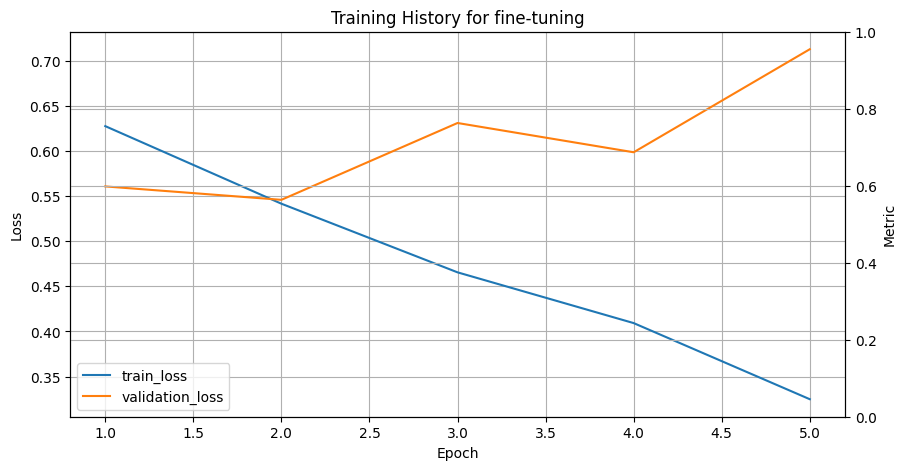

In [15]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

In [16]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=0.4540649581660329, lora_rank=8, lora_init_scale=0.01054546478690803, lora_scaling_rank=3)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [ ]:
# def save_model(model, filepath):
#     torch.save(model.state_dict(), filepath)

# save_model(model, "../finetuned_model.pth")

lr 0.0007818596894056708

batch 4

accum 4

dropout_rate 0.4540649581660329

weight_decay 1.0585189745148587e-05

warmup_pct 0.01886939819712101

lora_rank 8

lora_init_scale 0.01054546478690803

lora_scaling_rank 3

In [17]:
# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_all_bfd.pth",num_labels=2)

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 6508547.0



In [18]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [ ]:
# model = from_pretrained("model_output")

In [19]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/test_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])
    
local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WUI4|HDAC7_HUMAN%342%358,ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM,1
1,sp|Q13950|RUNX2_HUMAN%416%432,THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG,1
2,sp|Q15796|SMAD2_HUMAN%229%245,DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL,1
3,sp|P05787|K2C8_HUMAN%416%432,TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG,1
4,sp|Q92736|RYR2_HUMAN%2798%2814,MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN,1


In [20]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM      1
1  THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG      1
2  DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL      1
3  TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG      1
4  MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN      1


In [21]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = sequence.split()
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
my_test['middle_char'] = my_test['sequence'].apply(get_middle_char)

# Split the DataFrame
my_test_S = my_test[my_test['middle_char'] == 'S'].drop(columns=['middle_char'])
my_test_T = my_test[my_test['middle_char'] == 'T'].drop(columns=['middle_char'])
my_test_Y = my_test[my_test['middle_char'] == 'Y'].drop(columns=['middle_char'])
my_test_ST = my_test[my_test['middle_char'].isin(['S', 'T'])].drop(columns=['middle_char'])

In [26]:
my_test = my_test_Y

In [27]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.88it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.759615 |      0.884615 |         0.875 |       0.88 |  0.967949 |
+----------+---------------+---------------+------------+-----------+
[[23  3]
 [ 3 21]]


: 

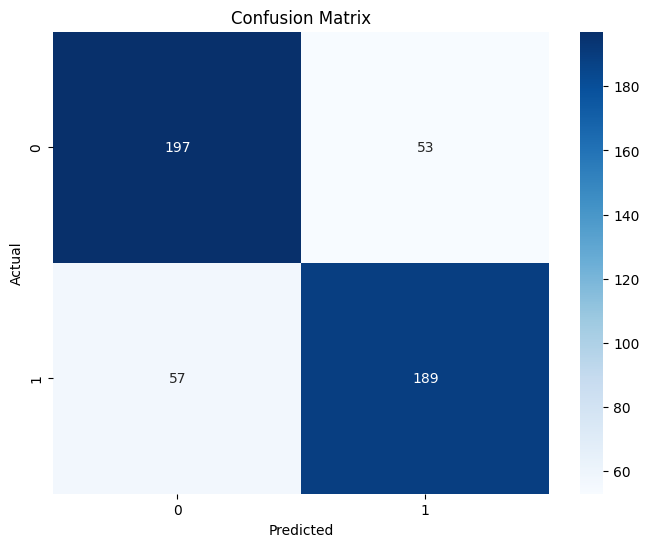

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()


In [24]:
my_test = my_test_ST

In [25]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|██████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.64it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.533671 |      0.776786 |      0.756757 |   0.766816 |  0.839125 |
+----------+---------------+---------------+------------+-----------+
[[174  50]
 [ 54 168]]


In [20]:
import umap

def apply_umap(embeddings, n_components=2, n_neighbors=5, min_dist=0.01, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_umap(embeddings, labels):
    df = pd.DataFrame({
        "UMAP1": embeddings[:, 0],
        "UMAP2": embeddings[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9
    )
    plt.title("UMAP Visualization of Embeddings")
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_ST.pdf", bbox_inches='tight')
    plt.show()
    
def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
    embeddings = []
    model = model.to(device)
    model.eval()

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
            embeddings.extend(hidden_states[:, 0, :])

        print(f"Processed batch {i // batch_size + 1}/{len(sequences) // batch_size + 1}")

    return np.array(embeddings)

In [38]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

valid_df = df

# Apply the function to get the middle characters
valid_df['middle_char'] = valid_df['sequence'].apply(get_middle_char)

valid_df = valid_df[valid_df['middle_char'] == 'T'].drop(columns=['middle_char'])

In [39]:
valid_df

,name,sequence,label
180,sp|Q9GZM8|NDEL1_HUMAN%203%219,CEKMDSAVQASLSLPATPVGKGTENTFPSPKAI,1
181,sp|Q8N163|CCAR2_HUMAN%438%454,EWEALCQQKAAEAAPPTQEAQGETEPTEQAPDA,1
182,sp|P10636-8|TAU_HUMAN%196%212,GYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAV,1
183,sp|Q02241|KIF23_HUMAN%434%450,QEVEVARPVDKAICGLTPGRRYRNQPRGPVGNE,1
184,sp|Q04206|TF65_HUMAN%419%435,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLG,1
...,...,...,...
441,sp|Q76N33|STALP_MOUSE%326%342,ENVEELFNVQDQHGLLTLGWIHTHPTQTAFLSS,0
442,sp|P49790|NU153_HUMAN%1098%1114,FVLGRTEEKQQEPVTSTSLVFGKKADNEEPKCQ,0
443,sp|Q8NFC6|BD1L1_HUMAN%2789%2805,DVLDSRIETAQRQCPETEPHDTKEENSRDLEEL,0
444,sp|Q5T6F2|UBAP2_HUMAN%514%530,SKIPASAVEMPGSADVTGLNVQFGALEFGSEPS,0


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0

Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


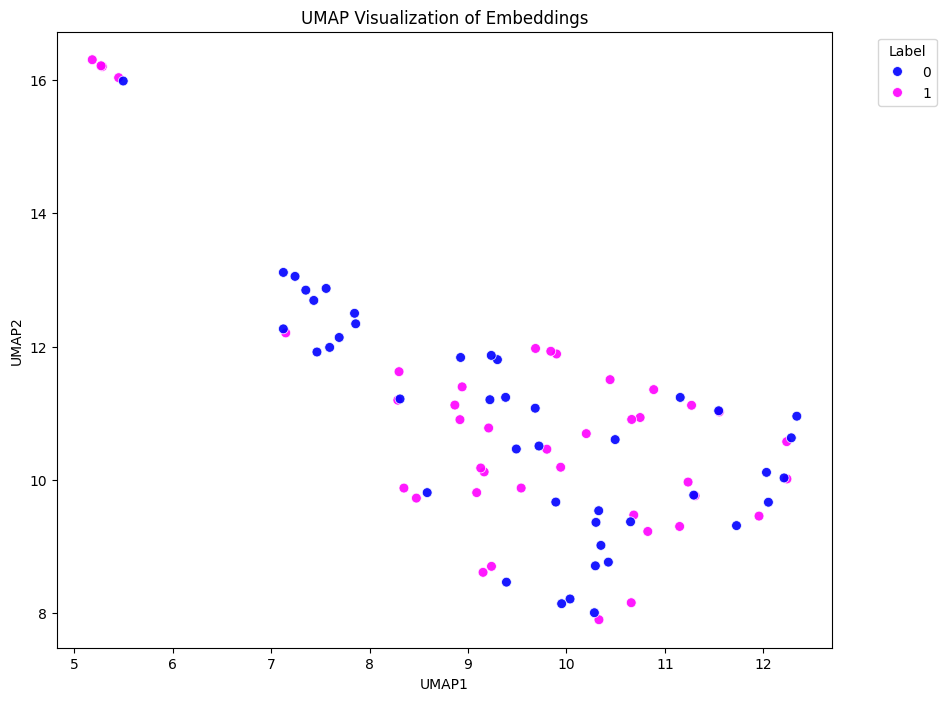

In [40]:
# valid_df = my_valid

# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].apply(lambda x: " ".join(x))

valid_sequences = list(valid_df['sequence'])
valid_embeddings = get_embeddings(model_reload, tokenizer, valid_sequences)

umap_embeddings = apply_umap(valid_embeddings)


labels = list(valid_df['label'])

plot_umap(umap_embeddings, labels)
